<a href="https://colab.research.google.com/github/Mirnada/Covid_19/blob/master/Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos dados do Covid_19

*   Ánalise geral do dataset sem a limpeza dos dados

> > visão geral dos dados

> > describe do dataset para dados numéricos

> > info para dados nominais



## Montando o Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Importando bibliotecas

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Datasets/dados-curso-completo.csv')

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
1658820,2020-03-13 17:26:18,broca,whoisdrill,oms: tamo tendo pandemia evitar\n conglomerado...,0,361,pt,NaN,NaN,NaN,NaN,NaN,[]
1658821,2020-05-12 13:02:34,Renato 🇧🇷,VerdadeExpress,"@OsmarTerra Sr. Osmar Terra, gostaria de ouvir...",0,4066,pt,NaN,NaN,NaN,NaN,NaN,[]
1658822,2020-03-19 18:16:30,eugeniocosta8,EugenioCosta8,CIENTISTA DE HARVARD PREVÊ QUE ATÉ 70% DO MUND...,3,5307,pt,NaN,NaN,NaN,NaN,NaN,['CORONAVIRUS']
1658823,2020-04-07 18:14:45,Wagner Mota - Seriedade + Geek,wagnermota75,"#BolsonaroTemRazaoSim porque, quando a prefeit...",0,1000,pt,NaN,NaN,NaN,NaN,NaN,['BolsonaroTemRazaoSim']
1658824,2020-06-02 16:04:51,Fotógrafo,omarcelogoulart,"Em meio a uma pandemia, estamos na luta também...",0,726,pt,São Félix do Araguaia,Brazil,BR,-53.0,-11.0,[]


## Dataset original - Estatísticas

### Apresentando os 10 primeiros registros

In [4]:
df.head(10)

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanci...,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]
3,2020-04-01 21:11:07,🚩,santosodeto,Fumaça de cigarro pode propagar coronavírus? h...,0,1885,pt,NaN,NaN,NaN,NaN,NaN,[]
4,2020-03-19 17:49:40,Nova Impressão,novaimpressao_,🚨Todos juntos contra COVID-19💪\n\nSolicite seu...,0,124,pt,Brasília,Brazil,BR,-47.8778,-15.77691,[]
5,2020-05-08 11:21:36,Marcel Silvano,marcelsilvano,"Importantes avanços! A pesquisa brasileira, a ...",4,2769,pt,Macaé,Brazil,BR,NaN,NaN,[]
6,2020-03-10 21:27:40,Teixeira Correia,LidadorNoticias,(Última hora) Volta ao Alentejo: Anulada por c...,0,39,pt,NaN,NaN,NaN,NaN,NaN,[]
7,2020-06-04 13:22:21,Thiago Moraes,ThiagoMoraesPB,João Pessoa tem queda no isolamento social por...,1,3578,pt,NaN,NaN,NaN,NaN,NaN,[]
8,2020-05-07 21:32:12,PT Brasil,ptbrasil,A #tvPT de hoje vai falar sobre a pandemia na ...,10,942696,pt,NaN,NaN,NaN,NaN,NaN,['tvPT']
9,2020-03-11 20:27:49,Niquito ;),NLazaroto,O Coronavirús causou uma pandemia e eu ainda n...,0,215,pt,NaN,NaN,NaN,NaN,NaN,[]


### Descrição das colunas do Dataset

In [9]:
# nomes das colunas
df.columns

Index(['data', 'usuario', 'apelido', 'texto', 'retweet', 'seguidores',
       'idioma', 'lugar', 'pais', 'sigla', 'latitude', 'longitude',
       'hashtags'],
      dtype='object')

* data: data do tweet do usuário
* usuario: nome do usuario
* apelido: apelido do usuário
* texto: texto publicado pelo usuário
* retweet: quantidade de vezes que o tweet foi replicado
* seguidores: quantidade de seguidores do usuário
* idioma: idioma do usuário
* lugar: lugar do usuário na publicação
* pais: país do usuário na publicação
* sigla: sigla do Estado do usuário
* latitude: posição geogŕafica do usuário 
* longitude: posição geográfica do usuário

In [12]:
# verificando os tipos de dados do Dataset
df.dtypes

data           object
usuario        object
apelido        object
texto          object
retweet         int64
seguidores      int64
idioma         object
lugar          object
pais           object
sigla          object
latitude      float64
longitude     float64
hashtags       object
dtype: object

### Analisando os dados numericos

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
retweet,1658825.0,197.853299,6337.641384,0.000000,0.000000,0.000000,0.000000,1.139763e+06
seguidores,1658825.0,32572.055193,368029.985029,0.000000,101.000000,380.000000,1470.000000,8.424125e+07
latitude,8720.0,-40.237583,20.808494,-123.120400,-47.864334,-43.955615,-38.453198,1.747893e+02
longitude,8720.0,-11.117100,19.169105,-37.818769,-23.305300,-19.624400,-7.120700,5.825778e+01


Ao gerar alguns dados estatísticos, podemos notas:
* a variável retwee

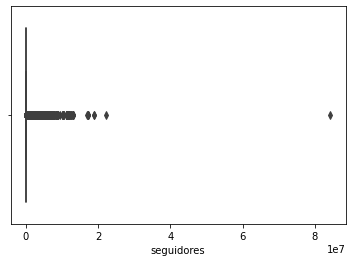

Fazendo uma contagem no texto

In [7]:
df['sigla'].value_counts()

BR    67247
PT     2675
US     1068
IT      484
ES      379
      ...  
IR        1
KR        1
MG        1
HN        1
CW        1
Name: sigla, Length: 120, dtype: int64


Analisando as palavras do texto

In [ ]:
textos = df['texto']

In [ ]:
print (textos)

0          @BolsonaroSP Cade o fundão deputado??? Congres...
1          Em ação preventiva, o Governo do Estado suspen...
2          Incrível como os defensores do fim do distanci...
3          Fumaça de cigarro pode propagar coronavírus? h...
4          🚨Todos juntos contra COVID-19💪\n\nSolicite seu...
                                 ...                        
1658820    oms: tamo tendo pandemia evitar\n conglomerado...
1658821    @OsmarTerra Sr. Osmar Terra, gostaria de ouvir...
1658822    CIENTISTA DE HARVARD PREVÊ QUE ATÉ 70% DO MUND...
1658823    #BolsonaroTemRazaoSim porque, quando a prefeit...
1658824    Em meio a uma pandemia, estamos na luta também...
Name: texto, Length: 1658825, dtype: object


Quebrando o texto em palavras

In [ ]:
texto_quebra = textos.str.split()

In [ ]:
print (texto_quebra)

0          [@BolsonaroSP, Cade, o, fundão, deputado???, C...
1          [Em, ação, preventiva,, o, Governo, do, Estado...
2          [Incrível, como, os, defensores, do, fim, do, ...
3          [Fumaça, de, cigarro, pode, propagar, coronaví...
4          [🚨Todos, juntos, contra, COVID-19💪, Solicite, ...
                                 ...                        
1658820    [oms:, tamo, tendo, pandemia, evitar, conglome...
1658821    [@OsmarTerra, Sr., Osmar, Terra,, gostaria, de...
1658822    [CIENTISTA, DE, HARVARD, PREVÊ, QUE, ATÉ, 70%,...
1658823    [#BolsonaroTemRazaoSim, porque,, quando, a, pr...
1658824    [Em, meio, a, uma, pandemia,, estamos, na, lut...
Name: texto, Length: 1658825, dtype: object


Analisando o primeiro indice 

In [ ]:
print (texto_quebra[0])

['@BolsonaroSP', 'Cade', 'o', 'fundão', 'deputado???', 'Congresso', 'está', 'sentado', 'em', '3BI', 'olhando', 'a', 'pandemia', 'da', 'janela.']


In [ ]:
len(texto_quebra)

1658825

In [ ]:
len(texto_quebra[0])

15

Pelo indice analisando entende-se que das 15 palavras a unica que nos interessa é a: 'pandemia', porem ainda não é o suficente.